In [1]:
"""
@author:  <Mohammed Awal Kassim>
@contact: <mkass005@uottawa.ca>
@version: 1.0
@summary: <This is the solution to the first homework of the CSI 5155(Machine Learning) course at the University of Ottawa.
          The aim of this learning task is to evaluate an individual's risk of drug consumption and misuse>
"""

# Importing useful libraries
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, recall_score, precision_score


### Declare all constants

In [2]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"
STORAGE_PATH = os.path.join("datasets", "drug")
FEATURES = ["id", "age", "gender", "education", "country", "ethnicity", "nscore", "escore", "oscore", "ascore", "cscore", "impulsive", "ss"]
CLASSES = ["alcohol", "amphet", "amyl", "benzos", "caff", "cannabis", "choc", "coke", "crack", "ecstasy", "heroine", "ketamin", "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]

### Fetch data from the UCI machine learning repository

In [3]:
def get_data(url = DATA_URL, path = STORAGE_PATH):
  """
  Fetches data from the internet given the url
  :param:url: location of dataset on the internet
  :param:path: destination in local environment
  """
  data = os.path.join(STORAGE_PATH, "drug_consumption.data")
  os.makedirs(path, exist_ok=True)
  urllib.request.urlretrieve(url, data)

### Load data into local workspace
- Given the original dataset has a .data extension, the feature names, which aren't available by default are assigned when reading the data.

In [4]:
def load_data(path = STORAGE_PATH):
  """
  Loads data from the local environment
  :param: path: data directory
  :return: pandas dataframe containing data
  """
  data_file = os.path.join(path, "drug_consumption.data")
  return pd.read_csv(data_file, names = FEATURES + CLASSES)

### Preprocess data
- Drop the irrelevant ID column
- Drop all instances where users claimed to have used semeron, since it is a fictitious drug introduced to identify over-claimers and ensure data quality.
- Drop the semeron class

In [5]:
def preprocess_data(data):
  """
  Performs data preprocessing 
  :param:data: pandas dataframe containing input data
  :return: pandas dataframe containing preprocessed data
  """
  data = data[data.semer == "CL0"]
  return data.drop(columns = ["id", "semer"])

### Feature Selection

In [6]:
def select_features(dataset):
  """
  Selects features that are relevant to the classification task using feature importance
  :param: dataset: input data
  :return: a dataframes containing selected features alongside their classes
  """
  class_name = dataset.columns[-1]
  class_name
  #new_classes.remove("semer")
  dataset.shape
  X_train = dataset.drop(dataset.columns[-1], axis=1)
  y_train = dataset[dataset.columns[-1]].copy()

  classifier = LogisticRegression()
  classifier.fit(X_train, y_train)
  model = SelectFromModel(classifier, prefit=True)
  feature_idx = model.get_support()
  feature_names = X_train.columns[feature_idx]
  print(feature_names)
  X_train_new = model.transform(X_train)
  X_train_new = pd.DataFrame(X_train_new, columns=feature_names)
  column_names = list(feature_names) + [class_name]
  X_train_new.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  new_data = pd.concat([X_train_new, y_train], axis=1, ignore_index=True)
  new_data.columns = column_names
  new_data.shape


  return new_data

### Convert multiclass problem to binary

In [7]:
def binarize_labels(data):
  """
  Converts the multi class labels to binary
  :param:data: pandas dataframe containing input data
  :return: six dataframes representing consumers of alcohol, amphet, cannabis, chocolate, mushrooms, and nicotine
  """
  new_classes = CLASSES.copy()
  new_classes.remove("semer")
  new_features = list(data.columns)[:len(data.columns)-len(new_classes)]
  for label in new_classes:
    data[label] = data[label].replace(["CL0", "CL1"], 0)
    data[label] = data[label].replace(["CL2", "CL3", "CL4", "CL5", "CL6"], 1)
    data[label].astype(float)

  # Drop all null values
  data.dropna(inplace=True)
     
  # Visualize the distribution of the new classes
  data[new_classes].hist(bins=50, figsize=(15,15))

  # Select classes that are less imbalanced
  amphet = data[new_features + ["amphet"]]
  benzos = data[new_features + ["benzos"]]
  cannabis = data[new_features+ ["cannabis"]]
  ecstasy = data[new_features + ["ecstasy"]]
  caff = data[new_features + ["caff"]]
  mushrooms = data[new_features + ["mushrooms"]]
  return amphet, benzos, cannabis, ecstasy, caff, mushrooms

### Model Construction

In [8]:
def split_data(data):
  """
  Splits data into train set and test set
  :param:data: input data
  :return: a tuple containing training and test set
  """
  train_set, test_set = train_test_split(data, test_size=0.33, random_state=42)

  return train_set, test_set

In [9]:
def make_models(train_data):
  """
  Fit training data to four algorithms(trees, random forests, KNNs, and SVMs)
  :param:train_data: Training data
  :return: four estimators fitted to the training data
  """
  # Get name of last column
  task = train_data.columns[-1]

  # Initialize all four estimators
  decision_tree = DecisionTreeClassifier(max_depth=2)
  random_forest = RandomForestClassifier(n_estimators=250)
  support_vector = SVC(kernel='rbf', random_state=42)
  nearest_neighbor = KNeighborsClassifier(n_neighbors=7)

  # Split train set into features and labels
  X_train = train_data.drop(task, axis=1)
  y_train = train_data[task].copy()

  # Fit all estimators
  decision_tree.fit(X_train, y_train)
  random_forest.fit(X_train, y_train)
  support_vector.fit(X_train, y_train)
  nearest_neighbor.fit(X_train, y_train)

  return decision_tree, random_forest, support_vector, nearest_neighbor


### Make Predictions

In [10]:
def make_predictions(test_set, task, trained_models):
  """
  Make inference using the test set
  :param:test_set: dataframe containing test samples
  :param:task: learning task
  :param:trained_models: tuple containing all four models
  :return: list of predictions made by all four models
  """

  X_test = test_set.drop(task, axis=1)
  y_test = test_set[task].copy()

  tree_predictions = trained_models[0].predict(X_test)
  forest_predictions = trained_models[1].predict(X_test)
  svm_predictions = trained_models[2].predict(X_test)
  knn_predictions = trained_models[3].predict(X_test)

  return tree_predictions, forest_predictions, svm_predictions, knn_predictions


### Compute recall and precision values

In [11]:
def calculate_recall_precision(labels, predictions):
  """
  Calculates the recall and precision for each estimator
  param:labels: true classes
  param:predictions: model predictions
  return: recall score and precision score
  """
  recall = recall_score(labels, predictions)
  precision = precision_score(labels, predictions)

  return recall, precision

### Visualize confusion matrix

In [12]:
def plot_confusion_matrix(labels, predictions, algorithm, axis, task):
  """
  Plot the confusion matrix for the classification
  param:labels: true classes
  param:predictions: model predictions
  """
  color_map = {
    "amphet": "Blues",
    "benzos": "Reds",
    "cannabis": "Greens",
    "ecstasy": "Oranges",
    "caff": "Greys",
    "mushrooms": "Purples"
  }
  axis.set_title(algorithm)
  ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap=color_map[task], colorbar=False, ax=axis, display_labels=['non-user', 'user'])


### Visualize ROC Curves

In [13]:
def plot_roc_curve(labels, predictions, algorithm, axis):
  """
  Plot the Receiver Operating Charasteristic (ROC) curve
  param:labels: true classes
  param:predictions: model predictions
  """
  RocCurveDisplay.from_predictions(labels, predictions, ax=axis, name=algorithm)

### Run Experiments

In [14]:
get_data()
drug_data = load_data()
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1885 non-null   int64  
 1   age        1885 non-null   float64
 2   gender     1885 non-null   float64
 3   education  1885 non-null   float64
 4   country    1885 non-null   float64
 5   ethnicity  1885 non-null   float64
 6   nscore     1885 non-null   float64
 7   escore     1885 non-null   float64
 8   oscore     1885 non-null   float64
 9   ascore     1885 non-null   float64
 10  cscore     1885 non-null   float64
 11  impulsive  1885 non-null   float64
 12  ss         1885 non-null   float64
 13  alcohol    1885 non-null   object 
 14  amphet     1885 non-null   object 
 15  amyl       1885 non-null   object 
 16  benzos     1885 non-null   object 
 17  caff       1885 non-null   object 
 18  cannabis   1885 non-null   object 
 19  choc       1885 non-null   object 
 20  coke    

#### Inspect first few rows of dataset

In [15]:
drug_data.head()

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,...,ecstasy,heroine,ketamin,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [16]:
drug_data.describe()

,id,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [17]:
drug_data[CLASSES].describe()

,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroine,ketamin,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,CL5,CL0,CL0,CL0,CL6,CL6,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
freq,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [18]:
new_drug_data = preprocess_data(drug_data)
new_drug_data.dropna(inplace=True)
new_drug_data.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,crack,ecstasy,heroine,ketamin,legalh,lsd,meth,mushrooms,nicotine,vsa
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0


#### Visualize the numerical attributes and their frequencies

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f18bef910>,
      dtype=object)

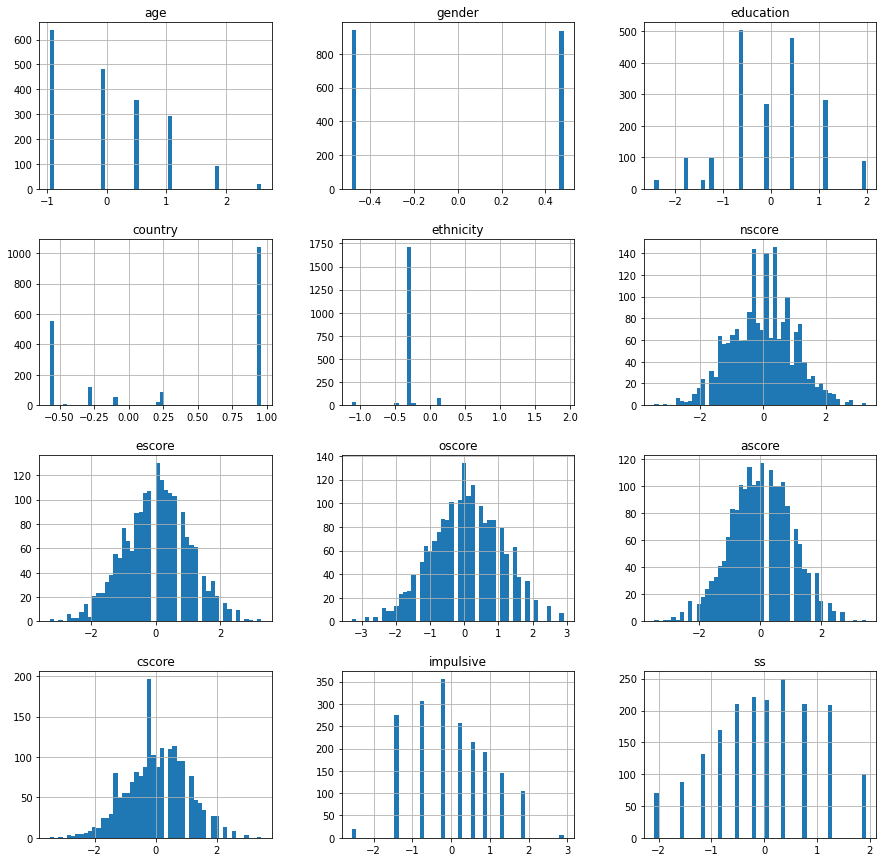

In [19]:
new_drug_data.hist(bins=50, figsize=(15,15))

Although the data is imbalanced, a simple histogram shows which classes are extremely skewed and should be avoided. The select classes are:
- Amphet
- Benzos
- Cannabis
- Legalh
- Mushrooms
- Ecstasy

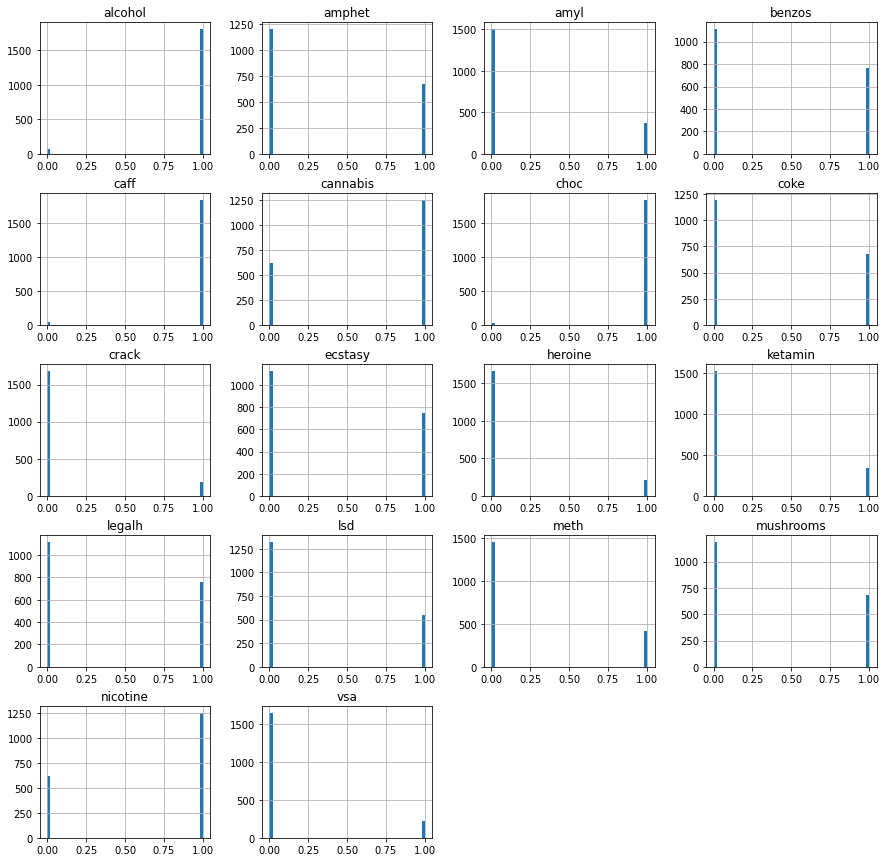

In [20]:
amphet, benzos, cannabis, ecstasy, caff, mushrooms = binarize_labels(new_drug_data)

### Learning Task 1 - Predicting risk of amphet consumption

In [21]:
recalls = []
precisions = []
features = []

******* Predicting risk of consuming amphet *******
Index(['age', 'gender', 'country', 'ss'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


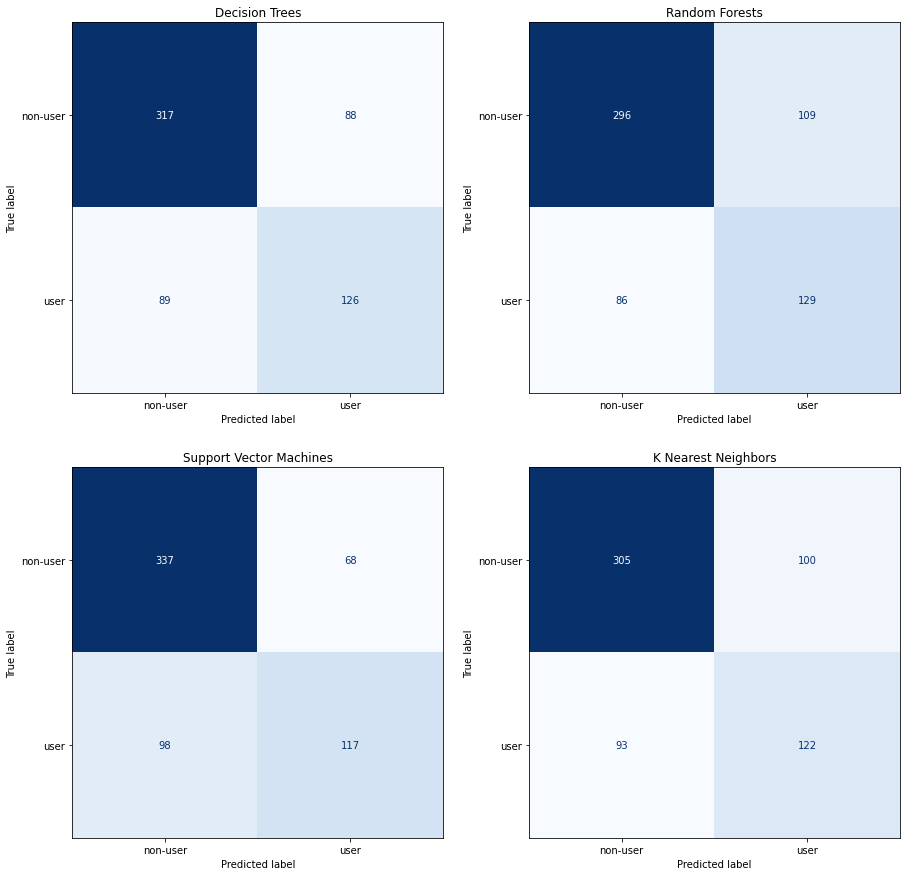

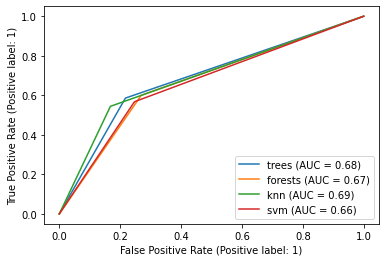

******* Predicting risk of consuming benzos *******
Index(['country', 'ethnicity', 'nscore'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


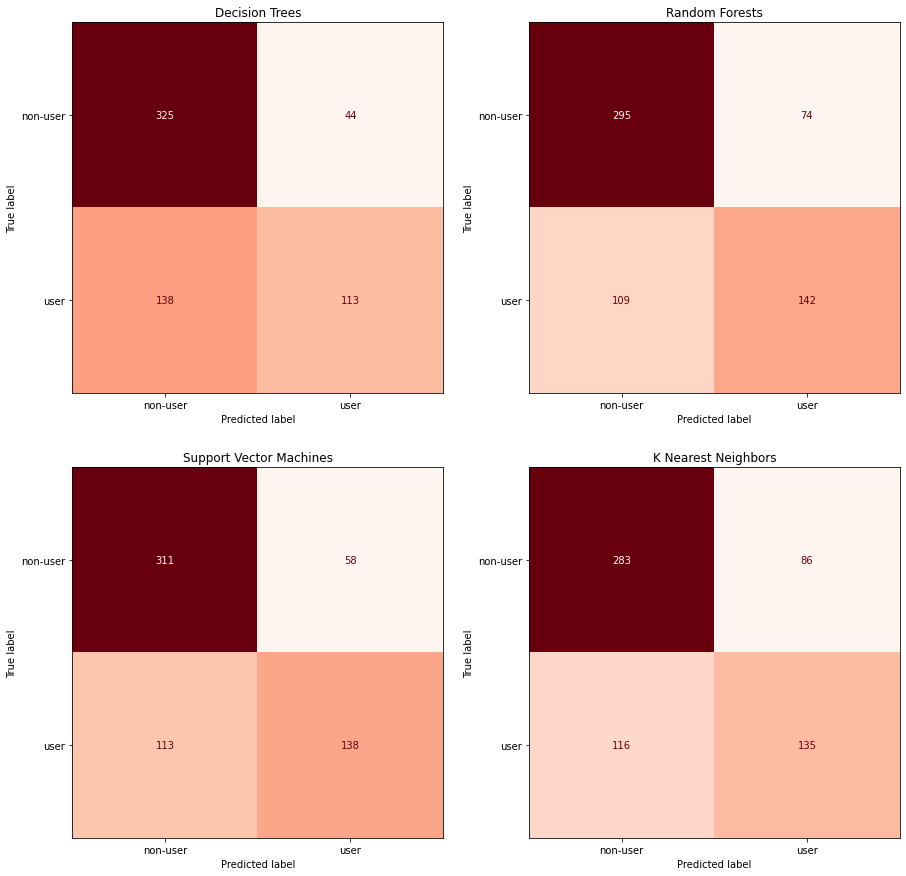

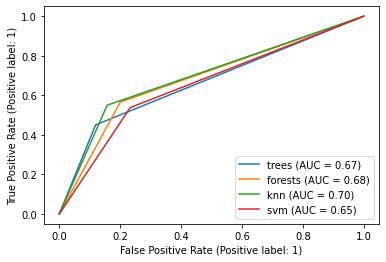

******* Predicting risk of consuming cannabis *******
Index(['age', 'country', 'ethnicity', 'oscore'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


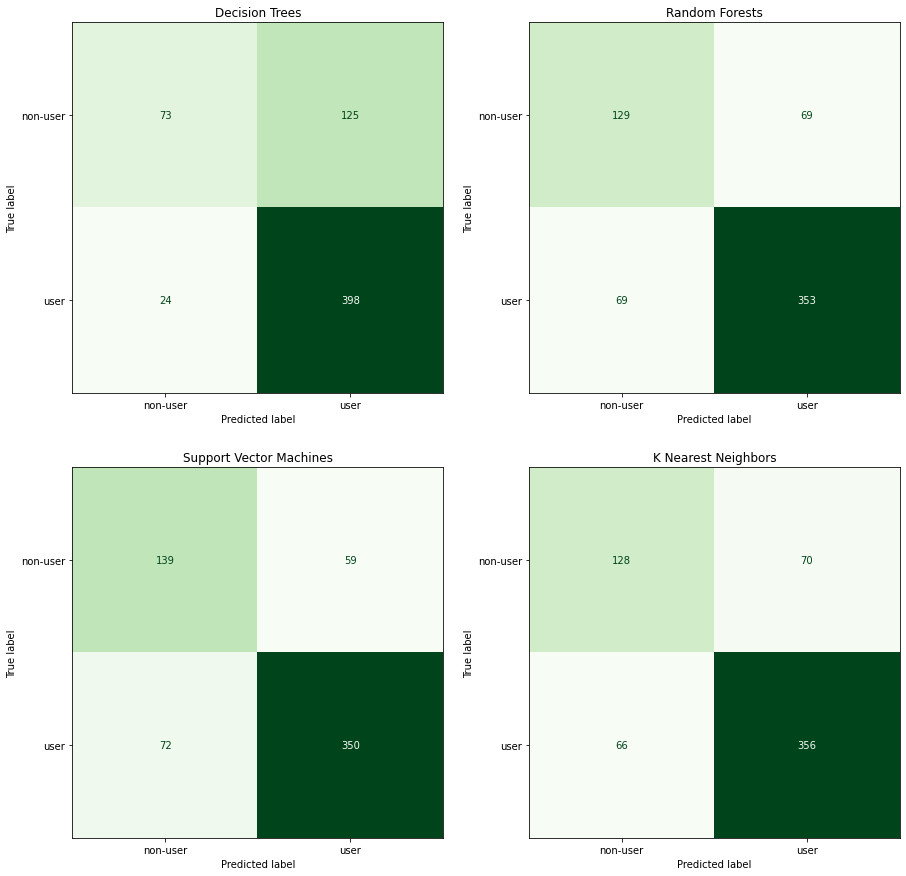

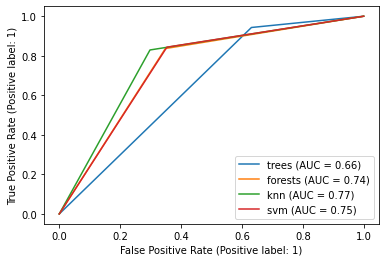

******* Predicting risk of consuming ecstasy *******
Index(['age', 'gender', 'country', 'oscore', 'ss'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


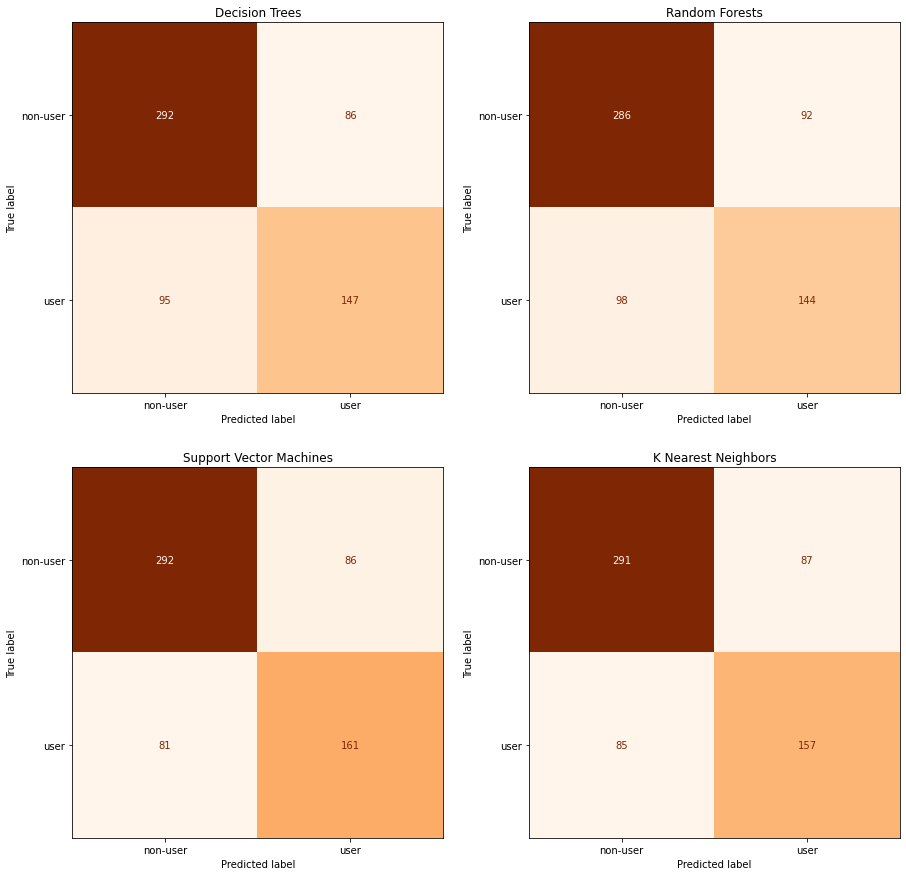

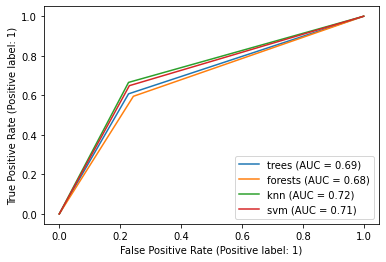

******* Predicting risk of consuming caff *******
Index(['age', 'country', 'ethnicity', 'escore', 'cscore'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


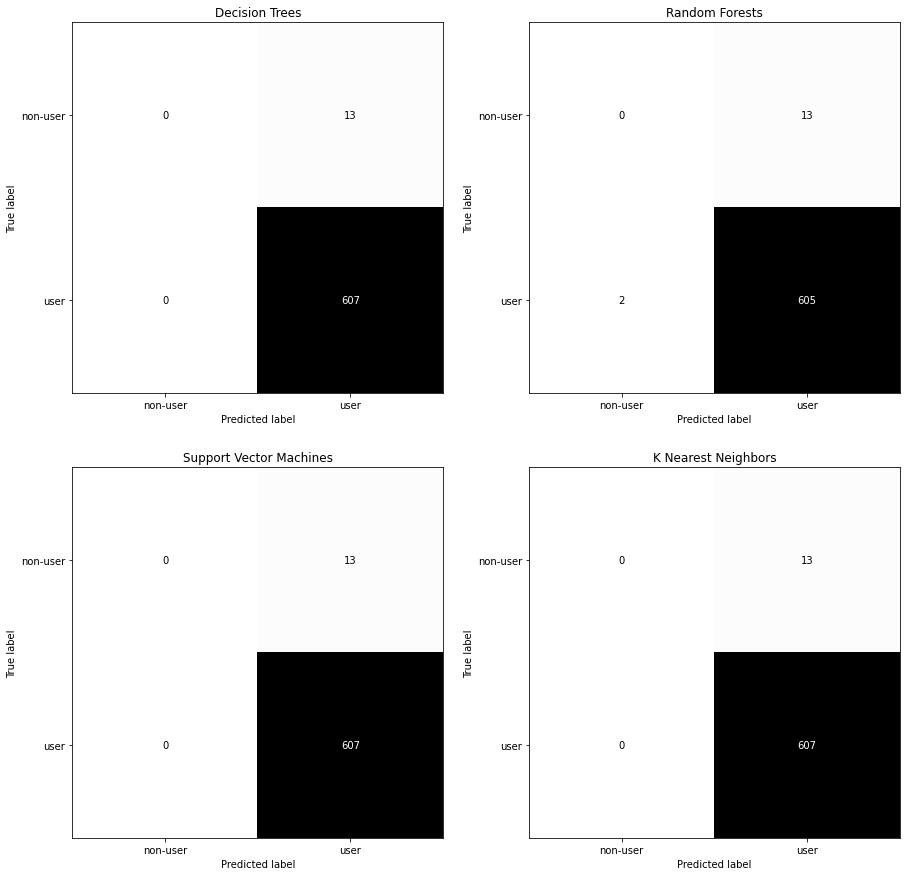

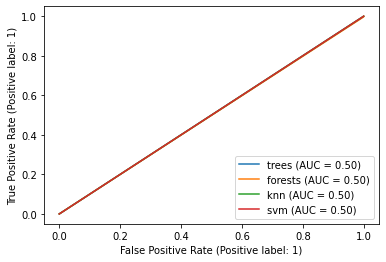

******* Predicting risk of consuming mushrooms *******
Index(['age', 'gender', 'country', 'ethnicity', 'oscore'], dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


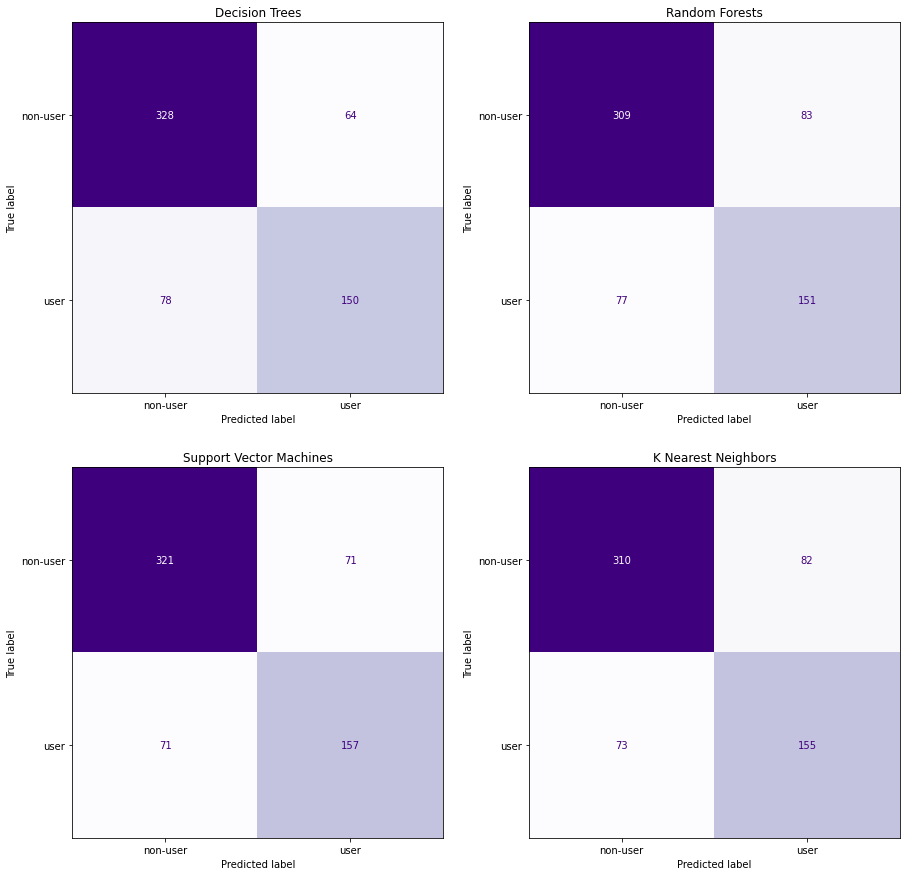

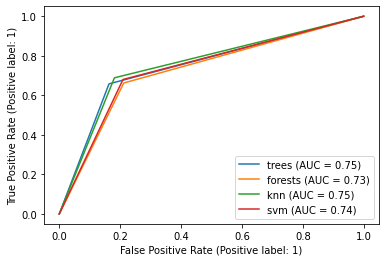

In [22]:
from pandas.core.ops.methods import add_flex_arithmetic_methods
learning_tasks = [amphet, benzos, cannabis, ecstasy, caff, mushrooms]

for task in learning_tasks:
  recall_precision = 0
  print(f"******* Predicting risk of consuming {task.columns[-1]} *******")
  new_task = select_features(task)
  #new_task 
  train_set, test_set = split_data(new_task)
  trained_models = make_models(train_set)
  predictions = make_predictions(test_set, new_task.columns[-1], trained_models)
  y_test = test_set[new_task.columns[-1]].copy()

  # Calculate recall and precision
  for index in range(len(predictions)):
    recall, precision = calculate_recall_precision(y_test, predictions[index])
    recalls.append(round(recall, 2))
    precisions.append(round(precision, 2))
  
  features.append(new_task.columns[:len(new_task.columns) - 1])


  # Plot confusion matrix
  fig, ax = plt.subplots(2, 2, figsize=(15, 15))
  plot_confusion_matrix(y_test, predictions[0], "Decision Trees", ax[0,0], new_task.columns[-1])
  plot_confusion_matrix(y_test, predictions[1], "Random Forests", ax[0,1], new_task.columns[-1])
  plot_confusion_matrix(y_test, predictions[2], "Support Vector Machines", ax[1,0], new_task.columns[-1])
  plot_confusion_matrix(y_test, predictions[3], "K Nearest Neighbors", ax[1,1], new_task.columns[-1])
  plt.show()

  # Plot ROC curves
  axis = plt.subplot()
  plot_roc_curve(y_test, predictions[0], "trees", axis)
  plot_roc_curve(y_test, predictions[1], "forests", axis)
  plot_roc_curve(y_test, predictions[2], "knn", axis)
  plot_roc_curve(y_test, predictions[3], "svm", axis)
  plt.show()

In [23]:






len(recalls)
len(precisions)
indices = []
recall_precision = []

# Get all recall precision scores
for i in range(len(recalls)):
  recall_precision.append(recalls[i] + precisions[i])
# Get indices of highest recall precision scores
recall_precision = np.array(recall_precision)
recall_precision = recall_precision.reshape(6, 4)
for i in range(recall_precision.shape[0]):
  indices.append(np.argmax(recall_precision[i]))

for i in range(len(indices)):
  indices[i] = indices[i] + (i * 4)

indices

[0, 6, 8, 14, 16, 22]

In [24]:
drugs = ["Amphetamines", "Benzodiazepines", "Cannabis", "Ecstasy", "Caffeine", "M Mushrooms"]
columns = ["drugs", "classifier", "precision", "recall"]

algorithms = {
    0 : "decision trees",
    1 : "random forests",
    2 : "svm",
    3: "knn"
}

best_recalls = [recalls[i] for i in indices]
best_precisions = [precisions[i] for i in indices]
best_algorithms = [algorithms[i%4] for i in indices]
best_recalls


[0.59, 0.55, 0.94, 0.67, 1.0, 0.69]

In [25]:
df = pd.DataFrame(list(zip(drugs, best_algorithms,  best_precisions, best_recalls)), columns=columns)

In [26]:
df = df.sort_values(by=["precision"], ascending=False, ignore_index=True)

In [27]:
df.to_csv("best_models.csv")

In [28]:
features = features[:6]
df2 = pd.DataFrame((features))
df2 = df2.T
df2.columns = drugs
df2.to_csv("selected_features.csv")

In [29]:
# Results from paper
classifiers1 = ["knn", "decision trees", "decision trees", "decision trees", "decision trees", "decision trees"]
# converted % values to floats
recall1 = [0.71, 0.68, 0.71, 0.66, 0.76, 0.81]

df3 = pd.DataFrame(list(zip(classifiers1, recall1)), columns=["paper classifier", "paper recall"])
df3

,paper classifier,paper recall
0,knn,0.71
1,decision trees,0.68
2,decision trees,0.71
3,decision trees,0.66
4,decision trees,0.76
5,decision trees,0.81


In [30]:
#df = df.reset_index(drop=True)
#df3 = df3.reset_index(drop=True)
comp = pd.concat([df, df3], axis=1, ignore_index=True)
comp

,0,1,2,3,4,5
0,Caffeine,decision trees,0.98,1.00,knn,0.71
1,Cannabis,decision trees,0.76,0.94,decision trees,0.68
2,Benzodiazepines,svm,0.70,0.55,decision trees,0.71
3,M Mushrooms,svm,0.69,0.69,decision trees,0.66
4,Ecstasy,svm,0.65,0.67,decision trees,0.76
5,Amphetamines,decision trees,0.59,0.59,decision trees,0.81


In [31]:
comp.columns = ["drug", "estimator", "recall", "precision", "estimator[1]", "recall[1]"]

In [32]:
comp.to_csv("comparison.csv")